In [1]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score, accuracy_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import albumentations as A
from math import ceil
from collections import Counter
from skimage.metrics import structural_similarity as ssim

In [2]:
# import sys
# sys.path.append("../")

# %load_ext autoreload
# %autoreload 2

### Prepare data

In [5]:
data_path = "../data/chest_xray"

In [6]:
dataset = torchvision.datasets.ImageFolder(root=data_path, 
                                 transform = None,
                                 target_transform = None,
                                 )

In [7]:
len(dataset)

5856

In [8]:
Counter(dataset.targets)

Counter({0: 1583, 1: 4273})

In [9]:
def visualize_classes(dataset: Dataset, classes: list = [0, 1], columns: int = 6, inv_normalize = None):
    np.random.seed(0)
    classes_ids = [[] for _ in range(len(classes))]
    for i, class_ in enumerate(classes):
        for _ in range(columns):
            id_ = np.random.randint(len(dataset), size=1)[0]
            while dataset[id_][1] != class_:
                id_ = np.random.randint(len(dataset), size=1)[0]
            classes_ids[i].append(id_)
    f, ax = plt.subplots(len(classes), columns)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(classes)):
        for j in range(columns):
            ax[i, j].set_title(f"id - {classes_ids[i][j]}; label - {dataset[classes_ids[i][j]][1]}")
            image = dataset[classes_ids[i][j]][0]
            if inv_normalize is not None:
                image = inv_normalize(image)
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()
            ax[i, j].imshow(image)
            ax[i, j].axis('off')

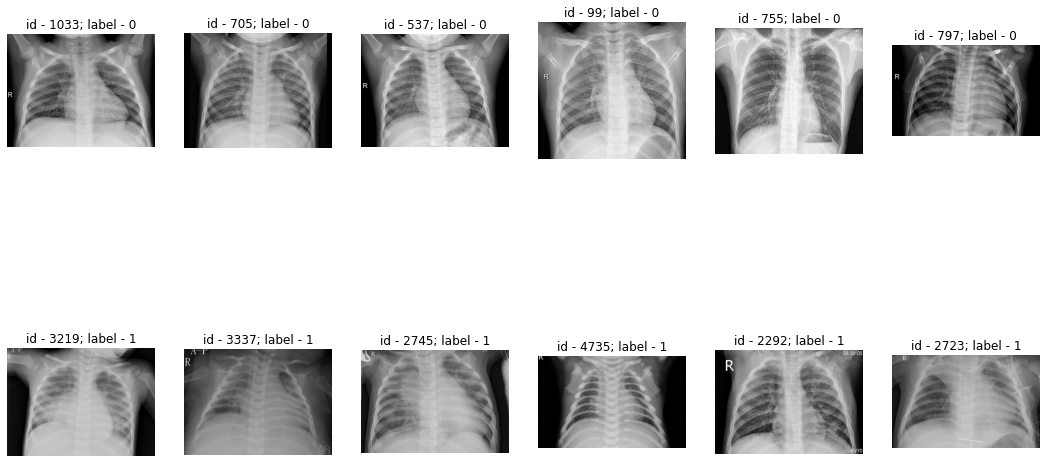

In [10]:
visualize_classes(dataset)

In [11]:
dataset = torchvision.datasets.ImageFolder(
    root=data_path, 
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    target_transform = None,
)

In [12]:
inv_normalize = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
])

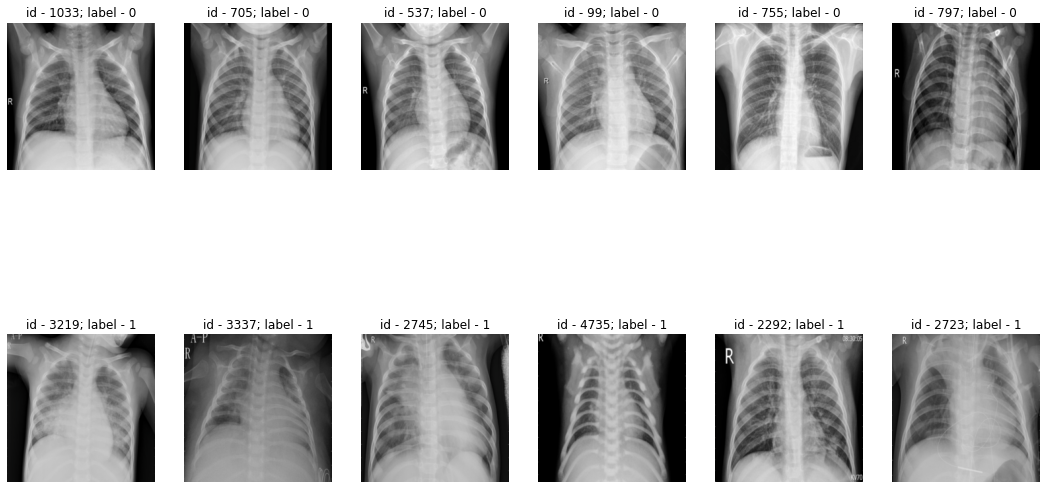

In [13]:
visualize_classes(dataset, inv_normalize=inv_normalize)

In [14]:
device = "cuda:0"
# device = "cpu"

In [15]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], torch.Generator().manual_seed(0)
)

In [16]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=0
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=True, num_workers=0
)

### Load model

In [17]:
save_path = "../models/5.1_resnext50_2021-04-13_02:31:08.pt"

In [18]:
model = models.resnext50_32x4d()
model.fc = nn.Sequential(
    nn.Linear(2048, 2),
    nn.Softmax(),
)

model.load_state_dict(torch.load(save_path))
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

### Analyze results

In [19]:
val_image = []
val_true = []
val_pred = []
val_prob = []
model.eval()
model.to(device)
with torch.no_grad():
    for inputs, batch_labels in tqdm(test_loader):
        inputs = inputs.to("cuda:0")
        outputs = model(inputs)
        prob = outputs.to("cpu").numpy()[:, 1]
        preds = (prob > 0.5).astype(int)
        val_prob.extend(prob)
        val_pred.extend(preds)
        val_true.extend(batch_labels.to("cpu").numpy())
        val_image.extend(inputs.to("cpu"))

100%|██████████| 37/37 [00:48<00:00,  1.30s/it]


In [20]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [21]:
df = pd.DataFrame({"true": val_true, "pred": val_pred, "prob": val_prob})

In [22]:
df["error_type"] = df.apply(error_class, axis=1)

In [23]:
df.groupby("error_type").count()

,true,pred,prob
error_type,,,
FN,14,14,14
FP,24,24,24
TN,283,283,283
TP,851,851,851


In [24]:
print(f"accuracy_score - {accuracy_score(df['true'], df['pred'])}")
print(f"average_precision_score - {average_precision_score(df['true'], df['pred'])}")

accuracy_score - 0.9675767918088737
average_precision_score - 0.9687757806004683


In [25]:
n = 10
def view_images(df: pd.DataFrame, images: np.ndarray, columns: int = 5, fig_size: tuple = (18.5, 10.5)):
    f, ax = plt.subplots(ceil(df.shape[0] / columns), columns)
    f.set_size_inches(*fig_size)
    for i, (id_, row) in enumerate(df.iterrows()):
        if ax.ndim  == 2:
            current_ax = ax[i // columns, i % columns]
        else:
            current_ax = ax[i]
        current_ax.set_title(str(row))
        current_ax.imshow(inv_normalize(images[id_]).permute(1, 2, 0).numpy())
        current_ax.axis('off')

In [26]:
df

,true,pred,prob,error_type
0,1,1,0.994537,TP
1,0,0,0.004485,TN
2,1,1,0.999359,TP
3,1,1,0.999856,TP
4,0,0,0.000752,TN
...,...,...,...,...
1167,1,1,0.999874,TP
1168,0,0,0.029472,TN
1169,0,0,0.000045,TN
1170,0,1,0.866388,FP


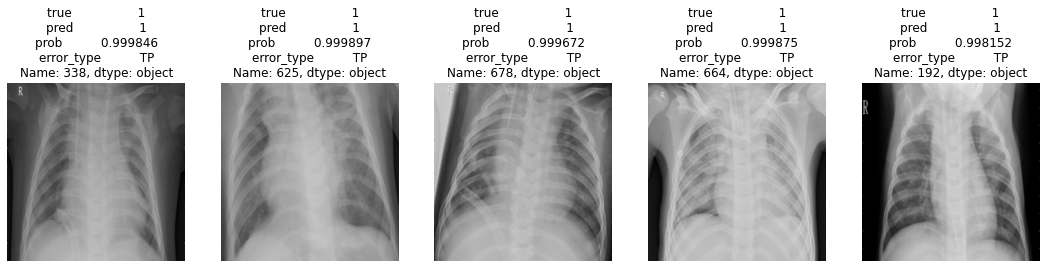

In [27]:
view_images(df[df["error_type"]=="TP"].sample(5), val_image)

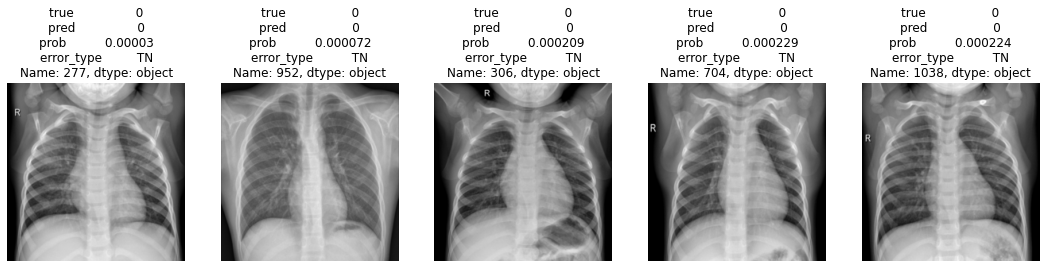

In [28]:
view_images(df[df["error_type"]=="TN"].sample(5), val_image)

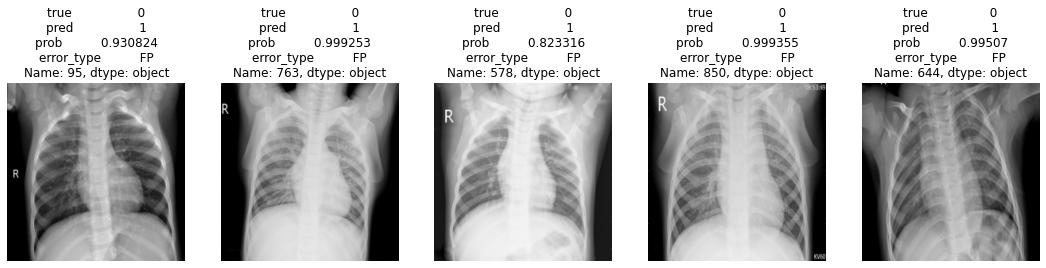

In [29]:
view_images(df[df["error_type"]=="FP"].sample(5), val_image)

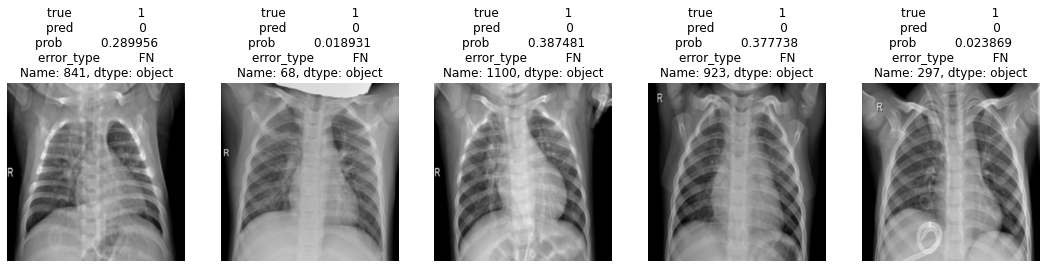

In [30]:
view_images(df[df["error_type"]=="FN"].sample(5), val_image)

### Attacks

In [31]:
# Load ART dependencies:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import to_categorical

In [32]:
image, label = dataset[0]
image = torch.unsqueeze(image, 0)
image = image.to(device)
output = model(image)
output = output.to("cpu").detach().numpy()[0, 1]

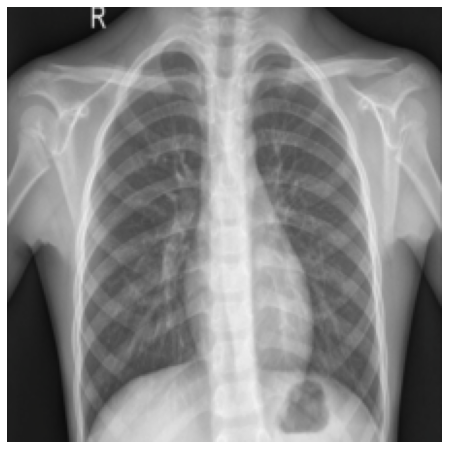

0.00041525456

In [33]:
img_to_show = inv_normalize(image[0].cpu()).permute(1, 2, 0)
plt.figure(figsize=(8,8))
plt.imshow(img_to_show)
plt.axis('off')
plt.show()
output

#### Art wrapper

In [34]:
from art.estimators.classification import PyTorchClassifier

In [35]:
art_classifier = PyTorchClassifier(
    model=model, 
    loss=nn.CrossEntropyLoss(), 
    input_shape=(3, 244, 244), 
    nb_classes=2
)

In [36]:
image, label = dataset[0]
image = torch.unsqueeze(image, 0)
output = art_classifier.predict(image)[0, 1]
print(output)

0.00041525456


#### Loss gradient 

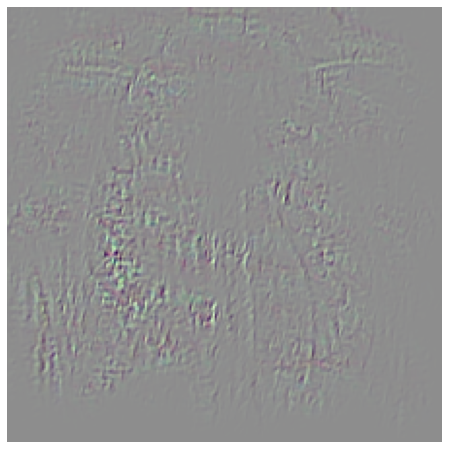

In [37]:
loss_gradient = art_classifier.loss_gradient(x=image, y=to_categorical([1], nb_classes=2))[0].permute(1, 2, 0).cpu().numpy()

# Let's plot the loss gradient. 
# First, swap color channels back to RGB order:
loss_gradient_plot = loss_gradient

# Then normalize loss gradient values to be in [0,1]:
loss_gradient_min = np.min(loss_gradient)
loss_gradient_max = np.max(loss_gradient)
loss_gradient_plot = (loss_gradient_plot - loss_gradient_min)/(loss_gradient_max - loss_gradient_min)

# Show plot:
plt.figure(figsize=(8,8))
plt.imshow(loss_gradient_plot)
plt.axis('off')
plt.show()

In [38]:
def norms(image, image_adv):
    img_original = inv_normalize(torch.tensor(image[0].cpu())).numpy() * 255
    img_adv = inv_normalize(torch.tensor(image_adv[0])).numpy() * 255

    l_0 = int(99*len(np.where(np.abs(img_original - img_adv)>0.5)[0]) / (224*224*3)) + 1   
    l_1 = int(99*np.sum(np.abs(img_original - img_adv)) / np.sum(np.abs(img_original))) + 1
    l_2 = int(99*np.linalg.norm(img_original - img_adv) / np.linalg.norm(img_original)) + 1 
    l_inf = int(99*np.max(np.abs(img_original - img_adv)) / 255) + 1

    print('Perturbation l_0 norm: %d%%' % l_0)
    print('Perturbation l_1 norm: %d%%' % l_1)
    print('Perturbation l_2 norm: %d%%' % l_2)
    print('Noise l_inf norm: %d%%' % l_inf)

    # Let's also plot the absolute amount of adversarial pixel perturbations:
    pert = img_original - img_adv
    pert_min = np.min(pert)
    pert_max = np.max(pert)

    plt.figure(figsize=(8,8))
    img_to_show = (pert - pert_min) / (pert_max - pert_min)
    img_to_show = np.transpose(img_to_show, (1, 2, 0))
    plt.imshow(img_to_show)
    plt.axis('off')
    plt.show()

### Metrics

#### Original data

In [39]:
def get_misclassification_rate(df):
    errors = df.groupby("error_type").count().T.iloc[0]
    misclassification_rate = (errors["FP"] + errors["FN"]) / errors.sum() * 100
    return misclassification_rate

In [40]:
def get_robustness_to_gaussian_blur(df_blur, df_orig):
    robustness_to_gaussian_blur = len(df_blur[df_blur["pred"]!=df_blur["true"]]) / len(df_orig[df_orig["pred"]!=df_orig["true"]])
    return robustness_to_gaussian_blur

In [41]:
def get_av_ssim(orig_images, adv_images):
    values = []
    for i in tqdm(range(len(orig_images))):
        values.append(ssim(np.transpose(orig_images[i], (1, 2, 0)), np.transpose(adv_images[i], (1, 2, 0)), multichannel=True))
    return np.mean(values)

In [42]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [43]:
def get_preds(adv = None, batch_size=1, max_iter=None):
    prob = []
    pred = []
    true = []
#     images = []
#     original_images = []
    
    if max_iter is not None:
        loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=True, num_workers=1
        )
    else:
        loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=1
        )
    counter = 0
    for image, label in tqdm(loader, total=max_iter if max_iter is not None else len(loader)):
#         if max_iter is not None:
#             original_images.append(np.array(image[0]).copy())
        if adv is not None:
            image = adv.generate(image.cpu(), y=to_categorical([1-label], nb_classes=2))
        pred_adv = art_classifier.predict(image)[:,1].reshape(-1)
        prob.extend(list(pred_adv))
        pred.extend(list((pred_adv > 0.5).astype(int)))
        true.extend(list(label.numpy().reshape(-1)))
#         images.append(np.array(image[0]))
        if max_iter is not None:
            counter += 1
            if counter >= max_iter:
                break

    df = pd.DataFrame({"prob":prob, "pred":pred, "true":true})
    df["error_type"] = df.apply(error_class, axis=1)
    return df
    if max_iter is not None:
        return df, np.array(images), np.array(original_images)
    else:
        return df, np.array(images)

In [44]:
df_orig = get_preds()

100%|██████████| 1172/1172 [00:26<00:00, 44.03it/s]


In [45]:
misclassification_rate = get_misclassification_rate(df_orig)
misclassification_rate

3.242320819112628

In [46]:
# df_orig_blur, orig_blur_images = get_preds(blur=True)

In [47]:
# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_orig_blur, df_orig)
# robustness_to_gaussian_blur

In [48]:
# misclassification_rate = get_misclassification_rate(df_orig_blur)
# misclassification_rate

In [49]:
# average_ssim = get_av_ssim(orig_images, orig_blur_images)
# average_ssim

#### ProjectedGradientDescent

In [50]:
adv = ProjectedGradientDescent(art_classifier, targeted=True, max_iter=50, eps_step=1, eps=0.02)

In [51]:
df_pgd = get_preds(adv, batch_size=1, max_iter=111)

  0%|          | 0/111 [00:00<?, ?it/s]

  1%|          | 1/111 [00:02<05:16,  2.88s/it]

  2%|▏         | 2/111 [00:05<05:06,  2.81s/it]

  3%|▎         | 3/111 [00:08<04:57,  2.76s/it]

  4%|▎         | 4/111 [00:10<04:52,  2.73s/it]

  5%|▍         | 5/111 [00:13<04:47,  2.72s/it]

  5%|▌         | 6/111 [00:16<04:42,  2.69s/it]

  6%|▋         | 7/111 [00:18<04:38,  2.68s/it]

  7%|▋         | 8/111 [00:21<04:35,  2.68s/it]

  8%|▊         | 9/111 [00:24<04:33,  2.68s/it]

  9%|▉         | 10/111 [00:26<04:28,  2.66s/it]

 10%|▉         | 11/111 [00:29<04:24,  2.64s/it]

 11%|█         | 12/111 [00:32<04:21,  2.64s/it]

 12%|█▏        | 13/111 [00:34<04:22,  2.68s/it]

 13%|█▎        | 14/111 [00:37<04:21,  2.69s/it]

 14%|█▎        | 15/111 [00:40<04:15,  2.66s/it]

 14%|█▍        | 16/111 [00:42<04:10,  2.64s/it]

 15%|█▌        | 17/111 [00:45<04:09,  2.65s/it]

 16%|█▌        | 18/111 [00:48<04:06,  2.65s/it]

 17%|█▋        | 19/111 [00:50<04:03,  2.65s/it]

 18%|█▊        | 20/111 [00:53<03:59,  2.64s/it]

 19%|█▉        | 21/111 [00:55<03:56,  2.63s/it]

 20%|█▉        | 22/111 [00:58<03:54,  2.63s/it]

 21%|██        | 23/111 [01:01<03:50,  2.62s/it]

 22%|██▏       | 24/111 [01:03<03:47,  2.62s/it]

 23%|██▎       | 25/111 [01:06<03:45,  2.62s/it]

 23%|██▎       | 26/111 [01:09<03:45,  2.65s/it]

 24%|██▍       | 27/111 [01:11<03:41,  2.63s/it]

 25%|██▌       | 28/111 [01:14<03:38,  2.63s/it]

 26%|██▌       | 29/111 [01:16<03:35,  2.62s/it]

 27%|██▋       | 30/111 [01:19<03:33,  2.64s/it]

 28%|██▊       | 31/111 [01:22<03:30,  2.63s/it]

 29%|██▉       | 32/111 [01:24<03:26,  2.61s/it]

 30%|██▉       | 33/111 [01:27<03:23,  2.61s/it]

 31%|███       | 34/111 [01:29<03:21,  2.62s/it]

 32%|███▏      | 35/111 [01:32<03:19,  2.63s/it]

 32%|███▏      | 36/111 [01:35<03:18,  2.65s/it]

 33%|███▎      | 37/111 [01:37<03:14,  2.63s/it]

 34%|███▍      | 38/111 [01:40<03:12,  2.64s/it]

 35%|███▌      | 39/111 [01:43<03:10,  2.64s/it]

 36%|███▌      | 40/111 [01:45<03:07,  2.65s/it]

 37%|███▋      | 41/111 [01:48<03:03,  2.63s/it]

 38%|███▊      | 42/111 [01:51<03:00,  2.61s/it]

 39%|███▊      | 43/111 [01:53<02:58,  2.62s/it]

 40%|███▉      | 44/111 [01:56<02:54,  2.60s/it]

 41%|████      | 45/111 [01:58<02:49,  2.57s/it]

 41%|████▏     | 46/111 [02:01<02:46,  2.57s/it]

 42%|████▏     | 47/111 [02:04<02:47,  2.61s/it]

 43%|████▎     | 48/111 [02:06<02:46,  2.64s/it]

 44%|████▍     | 49/111 [02:09<02:43,  2.64s/it]

 45%|████▌     | 50/111 [02:11<02:36,  2.57s/it]

 46%|████▌     | 51/111 [02:14<02:33,  2.55s/it]

 47%|████▋     | 52/111 [02:16<02:33,  2.60s/it]

 48%|████▊     | 53/111 [02:19<02:33,  2.65s/it]

 49%|████▊     | 54/111 [02:22<02:34,  2.72s/it]

 50%|████▉     | 55/111 [02:25<02:30,  2.69s/it]

 50%|█████     | 56/111 [02:27<02:25,  2.65s/it]

 51%|█████▏    | 57/111 [02:30<02:22,  2.63s/it]

 52%|█████▏    | 58/111 [02:32<02:18,  2.61s/it]

 53%|█████▎    | 59/111 [02:35<02:14,  2.59s/it]

 54%|█████▍    | 60/111 [02:37<02:09,  2.54s/it]

 55%|█████▍    | 61/111 [02:40<02:05,  2.51s/it]

 56%|█████▌    | 62/111 [02:42<02:01,  2.48s/it]

 57%|█████▋    | 63/111 [02:45<01:58,  2.47s/it]

 58%|█████▊    | 64/111 [02:47<01:54,  2.45s/it]

 59%|█████▊    | 65/111 [02:50<01:51,  2.43s/it]

 59%|█████▉    | 66/111 [02:52<01:48,  2.42s/it]

 60%|██████    | 67/111 [02:54<01:46,  2.42s/it]

 61%|██████▏   | 68/111 [02:57<01:44,  2.43s/it]

 62%|██████▏   | 69/111 [02:59<01:42,  2.44s/it]

 63%|██████▎   | 70/111 [03:02<01:39,  2.44s/it]

 64%|██████▍   | 71/111 [03:04<01:36,  2.41s/it]

 65%|██████▍   | 72/111 [03:06<01:33,  2.39s/it]

 66%|██████▌   | 73/111 [03:09<01:31,  2.41s/it]

 67%|██████▋   | 74/111 [03:11<01:29,  2.42s/it]

 68%|██████▊   | 75/111 [03:14<01:26,  2.41s/it]

 68%|██████▊   | 76/111 [03:16<01:25,  2.44s/it]

 69%|██████▉   | 77/111 [03:19<01:22,  2.43s/it]

 70%|███████   | 78/111 [03:21<01:19,  2.41s/it]

 71%|███████   | 79/111 [03:23<01:17,  2.42s/it]

 72%|███████▏  | 80/111 [03:26<01:16,  2.46s/it]

 73%|███████▎  | 81/111 [03:29<01:15,  2.53s/it]

 74%|███████▍  | 82/111 [03:32<01:16,  2.65s/it]

 75%|███████▍  | 83/111 [03:34<01:16,  2.74s/it]

 76%|███████▌  | 84/111 [03:37<01:15,  2.81s/it]

 77%|███████▋  | 85/111 [03:40<01:14,  2.86s/it]

 77%|███████▋  | 86/111 [03:43<01:11,  2.87s/it]

 78%|███████▊  | 87/111 [03:46<01:08,  2.86s/it]

 79%|███████▉  | 88/111 [03:49<01:05,  2.86s/it]

 80%|████████  | 89/111 [03:52<01:05,  2.96s/it]

 81%|████████  | 90/111 [03:56<01:07,  3.20s/it]

 82%|████████▏ | 91/111 [04:00<01:07,  3.36s/it]

 83%|████████▎ | 92/111 [04:03<01:05,  3.46s/it]

 84%|████████▍ | 93/111 [04:07<01:03,  3.54s/it]

 85%|████████▍ | 94/111 [04:11<01:01,  3.60s/it]

 86%|████████▌ | 95/111 [04:15<00:58,  3.65s/it]

 86%|████████▋ | 96/111 [04:19<00:56,  3.76s/it]

 87%|████████▋ | 97/111 [04:22<00:52,  3.75s/it]

 88%|████████▊ | 98/111 [04:26<00:48,  3.74s/it]

 89%|████████▉ | 99/111 [04:30<00:44,  3.74s/it]

 90%|█████████ | 100/111 [04:34<00:41,  3.74s/it]

 91%|█████████ | 101/111 [04:37<00:37,  3.73s/it]

 92%|█████████▏| 102/111 [04:41<00:33,  3.74s/it]

 93%|█████████▎| 103/111 [04:45<00:29,  3.75s/it]

 94%|█████████▎| 104/111 [04:49<00:26,  3.74s/it]

 95%|█████████▍| 105/111 [04:52<00:22,  3.74s/it]

 95%|█████████▌| 106/111 [04:56<00:18,  3.74s/it]

 96%|█████████▋| 107/111 [05:00<00:14,  3.74s/it]

 97%|█████████▋| 108/111 [05:03<00:11,  3.73s/it]

 98%|█████████▊| 109/111 [05:07<00:07,  3.75s/it]

 99%|█████████▉| 110/111 [05:11<00:03,  3.75s/it]

 99%|█████████▉| 110/111 [05:15<00:02,  2.87s/it]


In [52]:
# df_pgd_blur, _ = get_preds(adv, batch_size=1, blur=True)

In [53]:
misclassification_rate = get_misclassification_rate(df_pgd)

# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_pgd_blur, df_pgd)

# average_ssim = get_av_ssim(orig_images, pgd_images)

In [54]:
misclassification_rate
# , robustness_to_gaussian_blur, average_ssim

57.65765765765766

#### BasicIterativeMethod

In [55]:
from art.attacks.evasion import BasicIterativeMethod, ElasticNet, FastGradientMethod

In [56]:
adv = BasicIterativeMethod(art_classifier, eps = 0.1, eps_step = 0.1, max_iter = 100, targeted = True)

In [57]:
df_bim = get_preds(adv, batch_size=1, max_iter=111)

  0%|          | 0/111 [00:00<?, ?it/s]

  1%|          | 1/111 [00:07<13:38,  7.44s/it]

  2%|▏         | 2/111 [00:14<13:32,  7.45s/it]

  3%|▎         | 3/111 [00:22<13:23,  7.44s/it]

  4%|▎         | 4/111 [00:29<13:16,  7.44s/it]

  5%|▍         | 5/111 [00:37<13:07,  7.43s/it]

  5%|▌         | 6/111 [00:44<12:58,  7.42s/it]

  6%|▋         | 7/111 [00:51<12:50,  7.41s/it]

  7%|▋         | 8/111 [00:59<12:42,  7.41s/it]

  8%|▊         | 9/111 [01:06<12:33,  7.38s/it]

  9%|▉         | 10/111 [01:14<12:26,  7.39s/it]

 10%|▉         | 11/111 [01:21<12:20,  7.41s/it]

 11%|█         | 12/111 [01:28<12:14,  7.41s/it]

 12%|█▏        | 13/111 [01:36<12:07,  7.42s/it]

 13%|█▎        | 14/111 [01:43<12:03,  7.46s/it]

 14%|█▎        | 15/111 [01:51<11:53,  7.43s/it]

 14%|█▍        | 16/111 [01:58<11:48,  7.46s/it]

 15%|█▌        | 17/111 [02:06<11:41,  7.46s/it]

 16%|█▌        | 18/111 [02:13<11:34,  7.47s/it]

 17%|█▋        | 19/111 [02:21<11:25,  7.45s/it]

 18%|█▊        | 20/111 [02:28<11:17,  7.45s/it]

 19%|█▉        | 21/111 [02:36<11:09,  7.44s/it]

 20%|█▉        | 22/111 [02:43<11:01,  7.43s/it]

 21%|██        | 23/111 [02:51<10:56,  7.46s/it]

 22%|██▏       | 24/111 [02:58<10:50,  7.48s/it]

 23%|██▎       | 25/111 [03:06<10:43,  7.48s/it]

 23%|██▎       | 26/111 [03:13<10:35,  7.47s/it]

 24%|██▍       | 27/111 [03:20<10:27,  7.47s/it]

 25%|██▌       | 28/111 [03:28<10:20,  7.48s/it]

 26%|██▌       | 29/111 [03:35<10:11,  7.46s/it]

 27%|██▋       | 30/111 [03:43<10:04,  7.47s/it]

 28%|██▊       | 31/111 [03:50<09:57,  7.47s/it]

 29%|██▉       | 32/111 [03:58<09:51,  7.49s/it]

 30%|██▉       | 33/111 [04:05<09:45,  7.50s/it]

 31%|███       | 34/111 [04:13<09:36,  7.49s/it]

 32%|███▏      | 35/111 [04:20<09:28,  7.47s/it]

 32%|███▏      | 36/111 [04:28<09:18,  7.45s/it]

 33%|███▎      | 37/111 [04:35<09:10,  7.44s/it]

 34%|███▍      | 38/111 [04:43<09:02,  7.43s/it]

 35%|███▌      | 39/111 [04:50<08:54,  7.42s/it]

 36%|███▌      | 40/111 [04:57<08:46,  7.42s/it]

 37%|███▋      | 41/111 [05:05<08:39,  7.42s/it]

 38%|███▊      | 42/111 [05:12<08:31,  7.41s/it]

 39%|███▊      | 43/111 [05:20<08:24,  7.42s/it]

 40%|███▉      | 44/111 [05:27<08:16,  7.40s/it]

 41%|████      | 45/111 [05:34<08:08,  7.41s/it]

 41%|████▏     | 46/111 [05:42<08:01,  7.41s/it]

 42%|████▏     | 47/111 [05:49<07:54,  7.42s/it]

 43%|████▎     | 48/111 [05:56<07:42,  7.34s/it]

 44%|████▍     | 49/111 [06:04<07:31,  7.28s/it]

 45%|████▌     | 50/111 [06:11<07:22,  7.26s/it]

 46%|████▌     | 51/111 [06:18<07:14,  7.24s/it]

 47%|████▋     | 52/111 [06:25<07:04,  7.19s/it]

 48%|████▊     | 53/111 [06:32<06:56,  7.18s/it]

 49%|████▊     | 54/111 [06:39<06:48,  7.16s/it]

 50%|████▉     | 55/111 [06:46<06:41,  7.17s/it]

 50%|█████     | 56/111 [06:54<06:34,  7.17s/it]

 51%|█████▏    | 57/111 [07:01<06:27,  7.17s/it]

 52%|█████▏    | 58/111 [07:08<06:20,  7.19s/it]

 53%|█████▎    | 59/111 [07:15<06:13,  7.18s/it]

 54%|█████▍    | 60/111 [07:22<06:05,  7.17s/it]

 55%|█████▍    | 61/111 [07:29<05:56,  7.14s/it]

 56%|█████▌    | 62/111 [07:37<05:50,  7.16s/it]

 57%|█████▋    | 63/111 [07:44<05:44,  7.18s/it]

 58%|█████▊    | 64/111 [07:51<05:36,  7.16s/it]

 59%|█████▊    | 65/111 [07:58<05:27,  7.13s/it]

 59%|█████▉    | 66/111 [08:05<05:19,  7.09s/it]

 60%|██████    | 67/111 [08:12<05:12,  7.11s/it]

 61%|██████▏   | 68/111 [08:19<05:06,  7.13s/it]

 62%|██████▏   | 69/111 [08:27<04:59,  7.14s/it]

 63%|██████▎   | 70/111 [08:34<04:51,  7.12s/it]

 64%|██████▍   | 71/111 [08:41<04:43,  7.08s/it]

 65%|██████▍   | 72/111 [08:48<04:37,  7.12s/it]

 66%|██████▌   | 73/111 [08:55<04:30,  7.13s/it]

 67%|██████▋   | 74/111 [09:02<04:24,  7.15s/it]

 68%|██████▊   | 75/111 [09:09<04:16,  7.14s/it]

 68%|██████▊   | 76/111 [09:16<04:10,  7.17s/it]

 69%|██████▉   | 77/111 [09:23<04:02,  7.12s/it]

 70%|███████   | 78/111 [09:31<03:56,  7.16s/it]

 71%|███████   | 79/111 [09:38<03:49,  7.16s/it]

 72%|███████▏  | 80/111 [09:45<03:42,  7.19s/it]

 73%|███████▎  | 81/111 [09:52<03:35,  7.17s/it]

 74%|███████▍  | 82/111 [09:59<03:27,  7.15s/it]

 75%|███████▍  | 83/111 [10:07<03:19,  7.14s/it]

 76%|███████▌  | 84/111 [10:14<03:12,  7.14s/it]

 77%|███████▋  | 85/111 [10:21<03:06,  7.16s/it]

 77%|███████▋  | 86/111 [10:28<02:58,  7.14s/it]

 78%|███████▊  | 87/111 [10:35<02:51,  7.16s/it]

 79%|███████▉  | 88/111 [10:42<02:44,  7.13s/it]

 80%|████████  | 89/111 [10:49<02:36,  7.12s/it]

 81%|████████  | 90/111 [10:56<02:29,  7.11s/it]

 82%|████████▏ | 91/111 [11:04<02:22,  7.12s/it]

 83%|████████▎ | 92/111 [11:11<02:14,  7.10s/it]

 84%|████████▍ | 93/111 [11:18<02:07,  7.07s/it]

 85%|████████▍ | 94/111 [11:25<02:00,  7.10s/it]

 86%|████████▌ | 95/111 [11:32<01:54,  7.13s/it]

 86%|████████▋ | 96/111 [11:39<01:46,  7.13s/it]

 87%|████████▋ | 97/111 [11:46<01:40,  7.15s/it]

 88%|████████▊ | 98/111 [11:53<01:32,  7.15s/it]

 89%|████████▉ | 99/111 [12:01<01:25,  7.16s/it]

 90%|█████████ | 100/111 [12:08<01:18,  7.14s/it]

 91%|█████████ | 101/111 [12:15<01:11,  7.12s/it]

 92%|█████████▏| 102/111 [12:22<01:04,  7.14s/it]

 93%|█████████▎| 103/111 [12:29<00:57,  7.16s/it]

 94%|█████████▎| 104/111 [12:36<00:50,  7.17s/it]

 95%|█████████▍| 105/111 [12:44<00:43,  7.19s/it]

 95%|█████████▌| 106/111 [12:51<00:35,  7.16s/it]

 96%|█████████▋| 107/111 [12:58<00:28,  7.17s/it]

 97%|█████████▋| 108/111 [13:05<00:21,  7.14s/it]

 98%|█████████▊| 109/111 [13:12<00:14,  7.15s/it]

 99%|█████████▉| 110/111 [13:19<00:07,  7.15s/it]

 99%|█████████▉| 110/111 [13:27<00:07,  7.34s/it]


In [58]:
# df_bim_blur, _ = get_preds(adv, batch_size=1, blur=True)

In [59]:
misclassification_rate = get_misclassification_rate(df_bim)

# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_bim_blur, df_bim)

# average_ssim = get_av_ssim(orig_images, bim_images)

In [60]:
misclassification_rate
# , robustness_to_gaussian_blur, average_ssim

100.0

#### ElasticNet

In [63]:
adv = ElasticNet(art_classifier, confidence=0.0, targeted= True, 
                     learning_rate = 0.1, 
                     binary_search_steps= 9, 
                     max_iter= 100, 
                     beta = 0.01,)

In [64]:
df_en  = get_preds(adv, batch_size=1, max_iter=11)

  0%|          | 0/11 [00:00<?, ?it/s]

  9%|▉         | 1/11 [02:52<28:42, 172.24s/it]

 18%|█▊        | 2/11 [05:43<25:48, 172.08s/it]

 27%|██▋       | 3/11 [08:35<22:54, 171.82s/it]

 36%|███▋      | 4/11 [11:26<20:02, 171.81s/it]

 45%|████▌     | 5/11 [13:43<16:07, 161.30s/it]

 55%|█████▍    | 6/11 [15:48<12:31, 150.34s/it]

 64%|██████▎   | 7/11 [17:52<09:29, 142.49s/it]

 73%|███████▎  | 8/11 [19:56<06:50, 136.95s/it]

 82%|████████▏ | 9/11 [22:01<04:26, 133.25s/it]

 91%|█████████ | 10/11 [24:06<02:10, 130.81s/it]

 91%|█████████ | 10/11 [26:12<02:37, 157.23s/it]

In [65]:
# df_en_blur, _, _ = get_preds(adv, batch_size=1, blur=True, max_iter=100)

In [66]:
misclassification_rate = get_misclassification_rate(df_en)

# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_en_blur, df_en)

# average_ssim = get_av_ssim(en_images_original, en_images)

In [67]:
misclassification_rate
# , robustness_to_gaussian_blur, average_ssim

100.0

#### Fast Gradient Method 

In [68]:
adv = FastGradientMethod(
        art_classifier,
        norm = 2, 
        eps = 10, 
        eps_step = 0.1, 
        targeted = True
    )

In [69]:
df_fgm = get_preds(adv, batch_size=1, max_iter=111)

 99%|█████████▉| 110/111 [00:10<00:00, 10.34it/s]


In [70]:
# df_fgm_blur, _ = get_preds(adv, batch_size=1, blur=True)

In [71]:
misclassification_rate = get_misclassification_rate(df_fgm)

# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_fgm_blur, df_fgm)

# average_ssim = get_av_ssim(orig_images, fgm_images)

In [72]:
misclassification_rate
# , robustness_to_gaussian_blur, average_ssim

79.27927927927928